In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import pearsonr
import itertools
#import numba

## K-Nearest Neighbors

In [5]:
data = pd.read_csv('data/diamonds.csv')
data.shape

(53940, 10)

In [6]:
data = data.dropna()
data = data.drop_duplicates()
#data['price'] = data['price'].astype('float64')
data.shape

(53794, 10)

In [7]:
data.head()


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


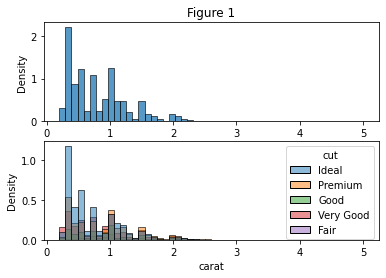

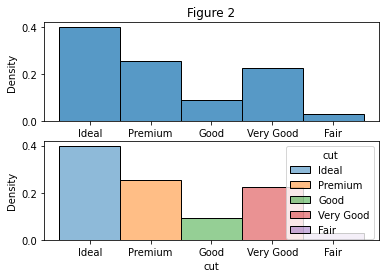

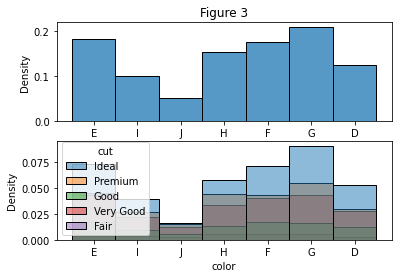

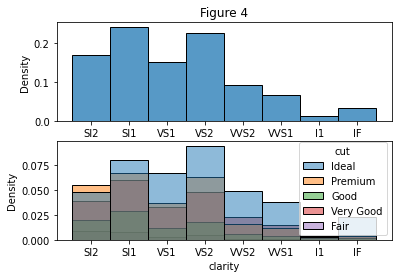

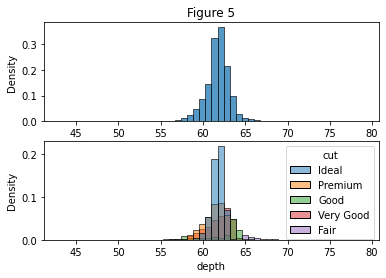

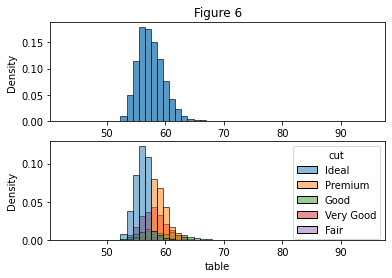

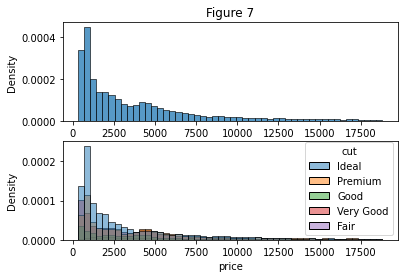

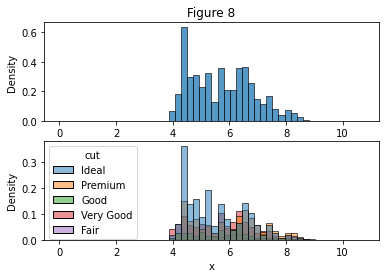

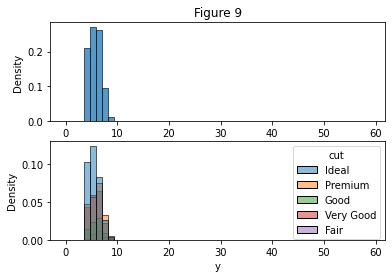

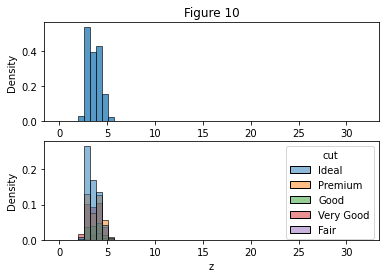

In [8]:
counter = 1
for col in data.columns:
    fig, axs = plt.subplots(2)
    axs[0].set_title("Figure {}".format(counter))
    sns.histplot(data[col], stat = 'density', bins=50, ax=axs[0])
    sns.histplot(data = data, x = col, hue = 'cut', stat = 'density', bins=50, ax=axs[1])
    counter +=1

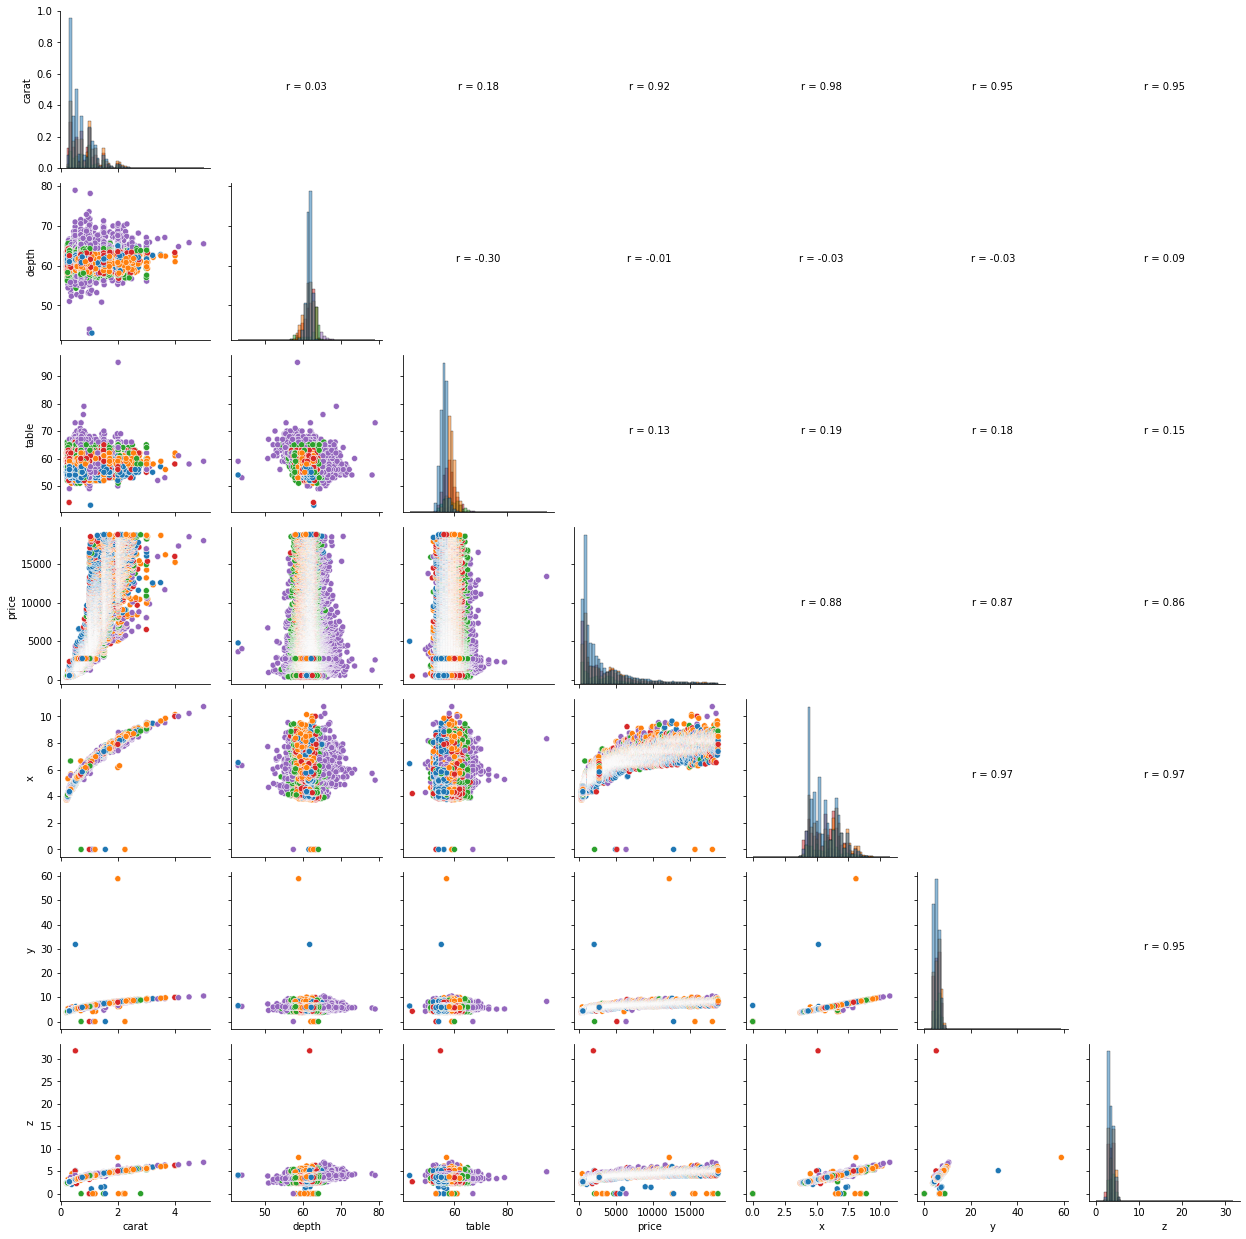

In [9]:
def coef_mapping(x, y, label=None, color=None, hue=None, ax=None, **kwargs):
    ax = plt.gca() # get current axis
    r,p = pearsonr(x,y)
    ax.set_axis_off() # turn off the axis
    ax.annotate('r = {:.2f}'.format(r), xy = (0.5, 0.5), xycoords='axes fraction', ha='center') # annotate the correlation
    

g = sns.PairGrid(data, diag_sharey=False, hue = 'cut')
g.map_diag(sns.histplot, bins = 50, stat = 'density')
g.map_lower(sns.scatterplot) 
g.map_upper(coef_mapping) 

In [10]:
numer_of_rows = data.shape[0]
# 60% for train, 20% for validation and 20% for test
train, validate, test = np.split(data.sample(frac = 1, random_state = 0), [int(.75*numer_of_rows), int(.90*numer_of_rows)])
train.reset_index(drop=True, inplace=True)
validate.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

validate.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.13,Premium,H,SI2,62.3,57.0,4873,6.68,6.65,4.15
1,1.02,Very Good,G,IF,62.3,59.0,8624,6.36,6.45,3.99
2,0.72,Ideal,E,SI2,61.3,55.0,2401,5.75,5.84,3.55
3,1.20,Premium,H,VS2,62.4,57.0,6048,6.73,6.67,4.18
4,1.00,Very Good,H,SI1,62.2,59.0,4830,6.32,6.35,3.94


In [11]:
def features_filter():
    filter = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
    return filter

In [12]:
def labels_filter():
    filter = ['cut', 'color', 'clarity']
    return filter

In [13]:
def split_X_and_y(dataset, lab_filter, features_filter):
    return (dataset[features_filter], dataset[lab_filter])


In [14]:
feat_filter = features_filter()
lab_filter = labels_filter()
X_test, y_test = split_X_and_y(test, lab_filter, feat_filter)
X_train, y_train = split_X_and_y(train, lab_filter, feat_filter)
X_validate, y_validate = split_X_and_y(validate, lab_filter, feat_filter)

In [15]:
class KNN:
    def __init__(self, distances = 'euclidean', k = 5):
        self.k = k
        if(distances != 'euclidean' and (distances.shape[0] != X_test.shape[0] or distances.shape[1] != X_train.shape[0])):
            raise Exception("Distance matrix not compatible with the number datapoints")
        self.distances = distances
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def classify(self, label = 'cut'):
        answ_class = []
        for i in range(self.distances.shape[0]):
            idx = np.argpartition(self.distances[i], self.k)[:self.k]
            closest_points = self.y_train.iloc[idx]
            answ_class.append(closest_points[label].mode()[0])
        return answ_class
        
    def predict(self, X_test):
        if (self.distances == 'euclidean'):
            self.distances = scipy.spatial.distance_matrix(X_test, self.X_train)
        predictions = self.classify()
        return predictions

    def accuracy(self, prediction, y_test):
        return ((y_test['cut'] == prediction).sum())/len(prediction)
       

In [16]:
features_subsets = np.asarray(list(itertools.combinations(X_test.columns,3)))
possibles_k = [2, 5, 10, 15]
len(features_subsets)

35

In [17]:
results = {}
for possible_k in possibles_k:
    print(possible_k)
    accuracys = []
    for feature_subset in features_subsets:
        clf = KNN(k=possible_k)
        clf.fit(X_train[feature_subset], y_train)
        prediction = clf.predict(X_test[feature_subset])
        clf_accuracy = clf.accuracy(prediction, y_test) 
        accuracys.append(clf_accuracy)
        %reset_selective -f clf
    results[possible_k] = accuracys         

2
5
10
15


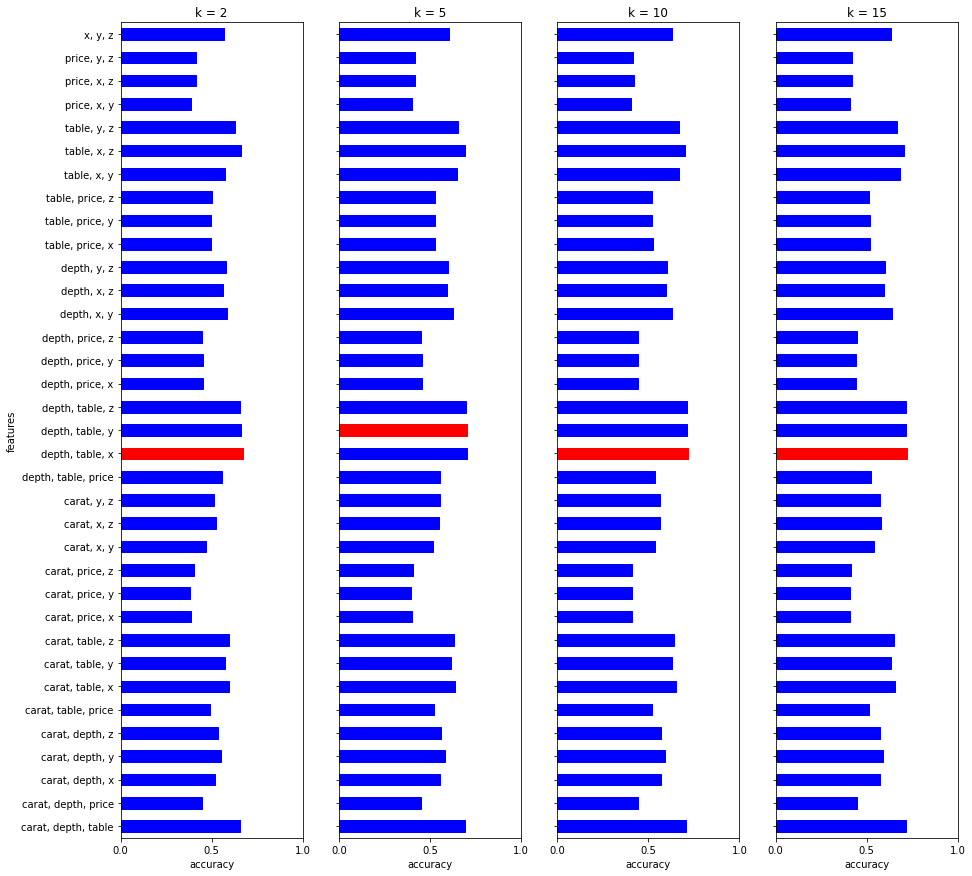

In [18]:
results_df = pd.DataFrame.from_dict(results)
new_column_features = [', '.join(feature) for feature in features_subsets]
results_df['features'] = new_column_features
results_df.index = new_column_features
#Single call to a plotting function
ax = results_df.plot(kind='barh', ylabel="features",subplots=True, layout=(1,len(possibles_k)), sharey=True, color='blue', xlim=[0,1], xticks = [0,0.5,1], figsize=(15,15), legend = False)

for i in range(len(possibles_k)):
    ax[0][i].set_xlabel("accuracy")
    ax[0][i].set_title(f"k = {possibles_k[i]}")
    max_for_k = max(results_df[possibles_k[i]])
    colors= ['red' if acc == max_for_k else 'blue' for acc in results_df[possibles_k[i]]]
    for bar, color in zip(ax[0][i].patches, colors):
        bar.set_color(color)
